In [1]:
import gc
import os
import operator

from glob import glob

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from pandas.core.categorical import Categorical
from scipy.sparse import csr_matrix, hstack

In [2]:
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8'
}


def sparse_dummies(df, column):
    """Returns sparse OHE matrix for the column of the dataframe"""
    categories = Categorical(df[column])
    column_names = np.array([f"{column}_{str(i)}" for i in range(len(categories.categories))])
    N = len(categories)
    row_numbers = np.arange(N, dtype=np.int)
    ones = np.ones((N,))
    return csr_matrix((ones, (row_numbers, categories.codes))), column_names

In [3]:
sorted(glob('../data/interim/train_2017-*_features.csv'))

['../data/interim/train_2017-11-08_0000_features.csv',
 '../data/interim/train_2017-11-08_0100_features.csv',
 '../data/interim/train_2017-11-08_0200_features.csv',
 '../data/interim/train_2017-11-08_0300_features.csv',
 '../data/interim/train_2017-11-08_0400_features.csv',
 '../data/interim/train_2017-11-09_0400_features.csv']

In [4]:
train_files = [
    '../data/interim/train_2017-11-08_0000_features.csv',
    '../data/interim/train_2017-11-08_0100_features.csv',
    '../data/interim/train_2017-11-08_0200_features.csv',
    '../data/interim/train_2017-11-08_0300_features.csv',
    '../data/interim/train_2017-11-08_0400_features.csv',
    '../data/interim/train_2017-11-09_0400_features.csv'
]

df_train = pd.concat([pd.read_csv(f, dtype=dtypes) for f in train_files], ignore_index=True)
gc.collect()

49

In [5]:
len(df_train)

20895140

In [6]:
train_size = 20895140 - 4032691

In [7]:
df_train.columns

Index(['COUNT(clicks)_channel_1hour',
       'MAX(clicks.app.COUNT(clicks))_channel_1hour',
       'MAX(clicks.app.NUM_UNIQUE(clicks.channel))_channel_1hour',
       'MAX(clicks.app.NUM_UNIQUE(clicks.device))_channel_1hour',
       'MAX(clicks.app.NUM_UNIQUE(clicks.os))_channel_1hour',
       'MAX(clicks.app.PERCENT_TRUE(clicks.is_attributed))_channel_1hour',
       'MAX(clicks.device.COUNT(clicks))_channel_1hour',
       'MAX(clicks.device.NUM_UNIQUE(clicks.app))_channel_1hour',
       'MAX(clicks.device.NUM_UNIQUE(clicks.channel))_channel_1hour',
       'MAX(clicks.device.NUM_UNIQUE(clicks.os))_channel_1hour',
       ...
       'SUM(clicks.os.COUNT(clicks))_channel_1hour',
       'SUM(clicks.os.NUM_UNIQUE(clicks.app))_channel_1hour',
       'SUM(clicks.os.NUM_UNIQUE(clicks.channel))_channel_1hour',
       'SUM(clicks.os.NUM_UNIQUE(clicks.device))_channel_1hour',
       'SUM(clicks.os.PERCENT_TRUE(clicks.is_attributed))_channel_1hour',
       'app', 'channel', 'device', 'is_attributed

In [8]:
categorical_features = ['app', 'device', 'os', 'channel']
numerical_features = [
    'COUNT(clicks)_channel_1hour',
    'PERCENT_TRUE(clicks.is_attributed)_channel_1hour',
    'NUM_UNIQUE(clicks.app)_channel_1hour',
    'NUM_UNIQUE(clicks.device)_channel_1hour',
    'NUM_UNIQUE(clicks.os)_channel_1hour',
    'STD(clicks.app.PERCENT_TRUE(clicks.is_attributed))_channel_1hour',
    'STD(clicks.device.PERCENT_TRUE(clicks.is_attributed))_channel_1hour',
    'STD(clicks.device.NUM_UNIQUE(clicks.os))_channel_1hour',
    'STD(clicks.os.NUM_UNIQUE(clicks.device))_channel_1hour',
    'SKEW(clicks.app.PERCENT_TRUE(clicks.is_attributed))_channel_1hour',
    'SKEW(clicks.device.COUNT(clicks))_channel_1hour',
    'SKEW(clicks.os.COUNT(clicks))_channel_1hour'
]

In [9]:
matrices = []
all_column_names = []
# creates a matrix per categorical feature
for c in categorical_features:
    matrix, column_names = sparse_dummies(df_train, c)
    matrices.append(matrix)
    all_column_names.append(column_names)

# appends a matrix for numerical features (one column per feature)
matrices.append(csr_matrix(df_train[numerical_features].values, dtype=float))
all_column_names.append(df_train[numerical_features].columns.values)

train_sparse = hstack(matrices, format="csr")
feature_names = np.concatenate(all_column_names)
del matrices, all_column_names

In [11]:
X = train_sparse
y = df_train['is_attributed']
# del df_train
gc.collect()

# Create binary training and validation files for XGBoost
x1, y1 = X[:train_size], y.iloc[:train_size]
dm1 = xgb.DMatrix(x1, y1, feature_names=feature_names)
dm1.save_binary('../data/cache/train.bin')
del dm1, x1, y1
gc.collect()

x2, y2 = X[train_size:], y.iloc[train_size:]
dm2 = xgb.DMatrix(x2, y2, feature_names=feature_names)
dm2.save_binary('../data/cache/validate.bin')
del dm2, x2, y2, X, y, train_sparse
gc.collect()

28

In [12]:
params = {
    'eta': 0.3,
    'tree_method': "hist",
    'grow_policy': "lossguide",
    'max_leaves': 1000,  
    'max_depth': 0, 
    'subsample': 0.9, 
    'alpha':1,
    'objective': 'binary:logistic', 
    'scale_pos_weight':100,
    'eval_metric': 'auc', 
    'nthread':25,
    'silent': 1
}

In [13]:
dmtrain = xgb.DMatrix('../data/cache/train.bin', feature_names=feature_names)
dmvalid = xgb.DMatrix('../data/cache/validate.bin', feature_names=feature_names)

# Training process
watchlist = [(dmtrain, 'train'), (dmvalid, 'valid')]
model = xgb.train(params, dmtrain, 50, watchlist, maximize=True, early_stopping_rounds=10, verbose_eval=1)

[0]	train-auc:0.968588	valid-auc:0.930759
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[1]	train-auc:0.970504	valid-auc:0.935537
[2]	train-auc:0.972004	valid-auc:0.939588
[3]	train-auc:0.972929	valid-auc:0.940568
[4]	train-auc:0.974161	valid-auc:0.9412
[5]	train-auc:0.975334	valid-auc:0.9413
[6]	train-auc:0.976535	valid-auc:0.94065
[7]	train-auc:0.977972	valid-auc:0.941722
[8]	train-auc:0.978959	valid-auc:0.942255
[9]	train-auc:0.979929	valid-auc:0.942115
[10]	train-auc:0.980679	valid-auc:0.942026
[11]	train-auc:0.981241	valid-auc:0.942487
[12]	train-auc:0.98172	valid-auc:0.94273
[13]	train-auc:0.981934	valid-auc:0.942958
[14]	train-auc:0.982131	valid-auc:0.942743
[15]	train-auc:0.982319	valid-auc:0.943077
[16]	train-auc:0.982477	valid-auc:0.943308
[17]	train-auc:0.982622	valid-auc:0.943518
[18]	train-auc:0.982751	valid-auc:0.943294
[19]	train-auc:0.98288	valid-auc:0.943097
[20]	train-auc:

In [14]:
importance = sorted(model.get_fscore().items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
df.sort_values('fscore', ascending=False).head(200)

,feature,fscore
501,COUNT(clicks)_channel_1hour,0.057701
500,PERCENT_TRUE(clicks.is_attributed)_channel_1hour,0.046618
499,STD(clicks.os.NUM_UNIQUE(clicks.device))_chann...,0.039826
498,STD(clicks.device.NUM_UNIQUE(clicks.os))_chann...,0.038074
497,STD(clicks.app.PERCENT_TRUE(clicks.is_attribut...,0.036823
496,NUM_UNIQUE(clicks.os)_channel_1hour,0.032247
495,SKEW(clicks.os.COUNT(clicks))_channel_1hour,0.032032
494,STD(clicks.device.PERCENT_TRUE(clicks.is_attri...,0.029494
493,SKEW(clicks.device.COUNT(clicks))_channel_1hour,0.028564
492,SKEW(clicks.app.PERCENT_TRUE(clicks.is_attribu...,0.028421


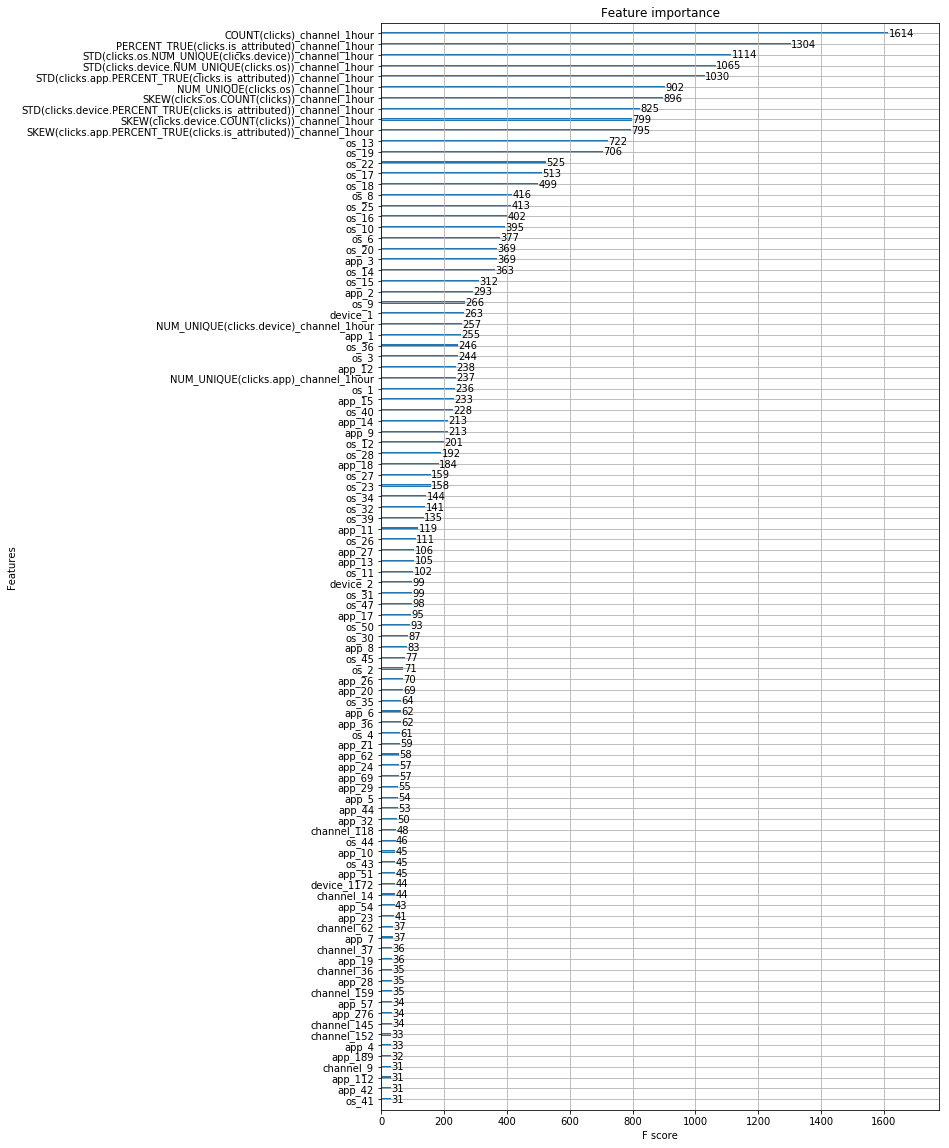

In [16]:
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model, ax=ax, max_num_features=100)